## LSTM model using univariate data to vector output
**Going to aggregate the data into hourly basis**

In [1]:
# coding: utf-8
# !/usr/bin/env python3
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import optimizers
import tensorflow as tf

In [2]:
# read dataset, if file is not available run: 1_Exploratory_Analylis.ipynb
df = pd.read_csv("./data/cleaned_household_power_consumption.csv", infer_datetime_format=True, parse_dates=["local_time"],
                index_col=["local_time"], dtype=np.float32)
# Just to be safer, data is already sorted
df.sort_index(inplace=True)

In [3]:
print("Data Range: ", df.index.min(), " to ", df.index.max())

Data Range:  2006-12-16 17:24:00  to  2010-11-26 21:02:00


**Not in scope:**    
As power is instantaneous reading, we will convert power to energy, and will predict the energy consumption in hours.
Ideally global_active_power is in kw, sub meters are in watt-hours, need convert this power to energy also the unit to watt-hour, not kw-hour.     
_**But just to showcase how models can be build, we won't go much into physics and aggregate accordingly, rather will just keep power as power and energy as energy for now**_

In [4]:
df = df.resample("H").sum()

In [5]:
df.head()

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3,sub_metering_other
local_time,,,,,,,,
2006-12-16 17:00:00,152.024002,8.243999,8447.179688,651.599976,0.0,19.0,607.0,1907.733398
2006-12-16 18:00:00,217.932007,4.802000,14074.809570,936.000000,0.0,403.0,1012.0,2217.199951
2006-12-16 19:00:00,204.013992,5.114000,13993.950195,870.200012,0.0,86.0,1001.0,2313.233398
2006-12-16 20:00:00,196.113998,4.506000,14044.290039,835.000000,0.0,0.0,1007.0,2261.566650
2006-12-16 21:00:00,183.388000,4.600000,14229.519531,782.799988,0.0,25.0,1033.0,1998.466675


**As we can see the first and last records don't have all the minutes, moreover the last records have only 2 minutes of data. So, I will get rid of this two records**

In [6]:
df = df[~df.index.isin(["2006-12-16 17:00:00", "2010-11-26 21:00:00"])]

In [7]:
df.shape

(34587, 8)

In [8]:
print("Data Range: ", df.index.min(), " to ", df.index.max())

Data Range:  2006-12-16 18:00:00  to  2010-11-26 20:00:00


### Strategies for hourly prediction (next 48 hours)
1. We will use sequence of **global_active_power** values to predict **global_active_power** itself. It's an univariate model.
2. We need to provide multi-step time forecast (asking for minutely forecast for 2 days ie. 2 * 24 data points). Data start and end is not from begining hour of the first day also not till end hour of last day.
3. For new prediction purpose, we will give 2 days prediction. That is 2010-11-24 21:00:00 to 2010-11-24 20:00:00.
4. Model can be trained using prior few days/hours data (here equivalent hours). We will start with using prior 2 days data (48 hours data) to train the model. It can be extended to any days, say 3, 4, 5 days. or if we look through hours, say 72, 100, 120 hours prior.
5. We will split the data into 3 sets (train, evaluate, test). And it will be in time series. And we will create a distict boundaries that no set can see the data from other set (be it the input sequence to train the model). We will keep last 48 + number of data in training as train set (if we don't do this, data will overlap). Here for test data, now we have 96 data points (considering, training with 48 data points). We will evaluate our model with 30 days (720 hours), so will keep next last 32 days data (768 hours). And remaining data points we will use for training our data.

### Train, Evaluate & Test split of univariate data:
**(I am not creating functions now, once we are clear and confident about our steps we can wrap different building blocks as functions)**

In [9]:
n_input = 2 * 24
n_output = 2 * 24
test_index_start = n_input + n_output
# 30 evaluation days
eval_days = 30
eval_index_start = n_input + eval_days * 24 + test_index_start
values = df.values
train, evaluate, test = values[:-eval_index_start], values[-eval_index_start:-test_index_start], values[-test_index_start:]
print("Training data shape: ", train.shape)
print("Evaluation data shape: ", evaluate.shape)
print("Test data shape: ", test.shape)

Training data shape:  (33723, 8)
Evaluation data shape:  (768, 8)
Test data shape:  (96, 8)


**We are getting evaluation and test data as mentioned in our startegy**    
Note: Still we have 8 features, we need only 1 feature (global_active_power in index 0) to build our univariate model

### Pre-processing:     
(I am not trying to make a pipeline here. Later while productionizing the model pipeline will make more sense).   
**Missing values imputation is already done, here I will to scale the data**    
Note: We can experiment with and without scaling, but for simplicity and faster learning will scale the features through out the project.
_I am going to use same strategy for multi-variate approach also as well as for different set of moddels. So, I will be saving the fitted scalar with all these 8 features for later use, though here I am using only 1 feature._

In [10]:
scalar = MinMaxScaler()
train_scaled = scalar.fit_transform(X=train)
eval_scaled = scalar.transform(X=evaluate)
test_scaled = scalar.transform(X=test)
print("Training scaled data shape: ", train_scaled.shape)
print("Evaluation scaled data shape: ", eval_scaled.shape)
print("Test scaled data shape: ", test_scaled.shape)

Training scaled data shape:  (33723, 8)
Evaluation scaled data shape:  (768, 8)
Test scaled data shape:  (96, 8)


In [11]:
# Saving this object for later use
joblib.dump(scalar, "./hourly_models/min_max_all_feat_48_to_48.pkl")

['./hourly_models/min_max_all_feat_48_to_48.pkl']

In [12]:
# Saving train, eval, test for later use
np.save("./hourly_models/train_scaled_48_to_48.npy", train_scaled)
np.save("./hourly_models/eval_scaled_48_to_48.npy", eval_scaled)
np.save("./hourly_models/test_scaled_48_to_48.npy", test_scaled)

In [13]:
# Check the available variables and free up memory
%whos

Variable             Type            Data/Info
----------------------------------------------
Dense                type            <class 'tensorflow.python<...>keras.layers.core.Dense'>
LSTM                 type            <class 'tensorflow.python<...>s.layers.recurrent.LSTM'>
MinMaxScaler         type            <class 'sklearn.preprocessing.data.MinMaxScaler'>
Sequential           type            <class 'tensorflow.python<...>e.sequential.Sequential'>
datetime             module          <module 'datetime' from '<...>hon37\\lib\\datetime.py'>
df                   DataFrame                            glob<...>n[34587 rows x 8 columns]
eval_days            int             30
eval_index_start     int             864
eval_scaled          ndarray         768x8: 6144 elems, type `float32`, 24576 bytes
evaluate             ndarray         768x8: 6144 elems, type `float32`, 24576 bytes
joblib               module          <module 'sklearn.external<...>ls\\joblib\\__init__.py'>
mean_squared

In [14]:
import psutil
print('memory % used:', psutil.virtual_memory()[2])

memory % used: 53.0


In [15]:
# deleting variables no longer required
del df, eval_days, eval_index_start, evaluate, test, test_index_start, train, values

### Preparing Input & Output dimensions

In [16]:
def get_X_y(data, n_in, n_out=48):
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensuring that we have enough data for this instance
        if out_end <= len(data):
            # need only 1 feature
            x_input = data[in_start:in_end, 0]
            # reshaping [timestemps, features]
            x_input = x_input.reshape((len(x_input), 1))
            # it will give [samples, timestemps, features]
            X.append(x_input)
            # [samples, output]
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return np.array(X), np.array(y)

In [17]:
X_train, y_train = get_X_y(data=train_scaled, n_in=n_input, n_out=n_output)
X_eval, y_eval = get_X_y(data=eval_scaled, n_in=n_input, n_out=n_output)
X_test, y_test = get_X_y(data=test_scaled, n_in=n_input, n_out=n_output)
print("Train X shape: ", X_train.shape)
print("Train y shape: ", y_train.shape)
print("Evaluation X shape: ", X_eval.shape)
print("Evaluation y shape: ", y_eval.shape)
print("Test X shape: ", X_test.shape)
print("Test y shape: ", y_test.shape)

Train X shape:  (33628, 48, 1)
Train y shape:  (33628, 48)
Evaluation X shape:  (673, 48, 1)
Evaluation y shape:  (673, 48)
Test X shape:  (1, 48, 1)
Test y shape:  (1, 48)


In [18]:
total_samples = X_train.shape[0] + X_eval.shape[0] + X_test.shape[0]
print("Train percent: {:.2f} %".format(X_train.shape[0]*100/total_samples))
print("Evaluation percent: {:.2f} %".format(X_eval.shape[0]*100/total_samples))
print("Test percent: {:.2f} %".format(X_test.shape[0]*100/total_samples))

Train percent: 98.04 %
Evaluation percent: 1.96 %
Test percent: 0.00 %


### Define and build models

In [19]:
# seeding the random number generation
seed = 101
np.random.seed(seed)
tf.set_random_seed(seed)
# defining parameters
learning_rate = 0.01
epochs = 50
batch_size = 16
verbose = 2
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

# define model
model = Sequential()
# This network is taking time: so getting rid of 1 dense layer
# model.add(LSTM(200, activation="tanh", input_shape=(n_timesteps, n_features)))
# model.add(Dense(100, activation="relu"))
# LSTM with 100 neurons in the first visible layer
model.add(LSTM(100, activation="tanh", input_shape=(n_timesteps, n_features)))
model.add(Dense(n_outputs))
# create optimizer unit to define learning rate
optmzr = optimizers.Adam(lr=learning_rate)
model.compile(loss="mse", optimizer=optmzr)
# don't want to see the tensorflow warnings
tf.logging.set_verbosity(tf.logging.ERROR)
# fit network
print("Training Started at: ", datetime.datetime.now())
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
print("Training Ended at: ", datetime.datetime.now())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Training Started at:  2019-10-06 15:37:47.959423
Epoch 1/50
 - 86s - loss: 0.0144
Epoch 2/50
 - 80s - loss: 0.0133
Epoch 3/50
 - 80s - loss: 0.0130
Epoch 4/50
 - 83s - loss: 0.0127
Epoch 5/50
 - 78s - loss: 0.0125
Epoch 6/50
 - 79s - loss: 0.0123
Epoch 7/50
 - 79s - loss: 0.0120
Epoch 8/50
 - 80s - loss: 0.0116
Epoch 9/50
 - 78s - loss: 0.0113
Epoch 10/50
 - 78s - loss: 0.0110
Epoch 11/50
 - 78s - loss: 0.0106
Epoch 12/50
 - 78s - loss: 0.0103
Epoch 13/50
 - 78s - loss: 0.0100
Epoch 14/50
 - 77s - loss: 0.0097
Epoch 15/50
 - 78s - loss: 0.0105
Epoch 16/50
 - 79s - loss: 0.0139
Epoch 17/50
 - 78s - loss: 0.0130
Epoch 18/50
 - 78s - loss: 0.0127
Epoch 19/50
 - 77s - loss: 0.0198
Epoch 20/50
 - 78s - loss: 0.0243
Epoch 21/50
 - 77s - loss: 0.0228
Epoch 22/50
 - 77s - loss: 0.0219
Epoch 23/50
 - 76s - loss: 0.0200
Epoch 24/50
 - 79s - loss: 0.0197
Epoch 25/50
 - 78s - los

### We can see that training took approximately 70 minutes. I have a CPU with i5 processor with 16 gb RAM. No GPU.   
**For faster processing, will try to use Google Colab**

In [91]:
# Saving the model and learned weights
# save model to JSON
model_json = model.to_json()
with open("./hourly_models/model_1/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("./hourly_models/model_1/model.h5")

### In above we didn't perform few steps like:
1. Using validation split and saving it to history to check model performance.
2. Checkpointing the best models.
**I will include these things in later models**

In [92]:
# only available part is training loss because of previously mentioned issues
model.history.history.keys()

dict_keys(['loss'])

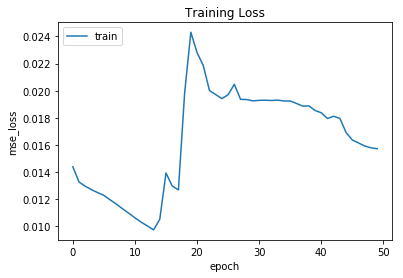

In [93]:
plt.plot(model.history.history["loss"])
plt.title("Training Loss")
plt.ylabel("mse_loss")
plt.xlabel("epoch")
plt.legend(["train"], loc='upper left');

### As we see, the loss was decreasing (less than 0.01) initial few epoch and then started raising and later it was coming back.
**Possibilities**
1. May be because of learning rate model went to some other region and struggling hard to move out from that region.
2. I should have saved the best model to use later.
3. Early stopping might help.
4. Need to try with other combinations and hyper parameter tunings.

#### Loss with evaluate dataset

In [94]:
model.evaluate(X_eval, y_eval)

673/673 [==============================] - 0s 288us/sample - loss: 0.0156


0.015584676107184139

#### Checking the actual forecast from the evaluate dataset

In [95]:
X_eval.shape

(673, 48, 1)

In [96]:
predictions = []
for arr in X_eval:
    # here array shape is (n_input, 1)
    yhat = model.predict(arr.reshape(1, n_input, 1))
    predictions.append(yhat)
predictions = np.array(predictions)

In [97]:
predictions.shape

(673, 1, 48)

In [98]:
y_eval.shape

(673, 48)

In [99]:
# we can check how far they lie
scores = list()
# calculate an RMSE score for each hour
# make the prediction shape as eval shape
pred = predictions.reshape(predictions.shape[0], predictions.shape[2])
#  0th index of scalar values will have details about global_active_power
mult_range = scalar.data_range_[0]
add_min = scalar.data_min_[0]
for i in range(y_eval.shape[1]):
    # convert to original scale, we have used MinMaxScalar
    y_eval_inverse = y_eval[:, i] * mult_range + add_min
    pred_inverse = pred[:, i] * mult_range + add_min
    # calculate mse
    mse = mean_squared_error(y_eval_inverse, pred_inverse)
    # calculate rmse
    rmse = np.sqrt(mse)
    # store
    scores.append(rmse)

Text(0,0.5,'Prediction Hours')

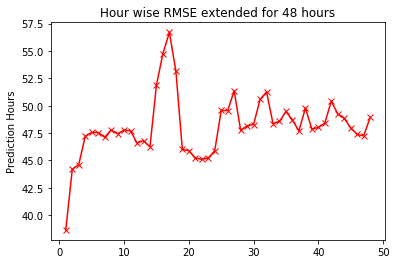

In [100]:
hours = np.arange(1,49)
plt.plot(hours, scores, marker='x', color="r")
plt.title("Hour wise RMSE extended for 48 hours")
plt.ylabel("RMSE global_active_power")
plt.ylabel("Prediction Hours")

### Though we don't have the best model, we can see that very short-term prediction is better compared to long term predictions.

In [101]:
# Checking overall RMSE
mult_range = scalar.data_range_[0]
add_min = scalar.data_min_[0]
overall_mse = mean_squared_error(y_eval.flatten() * mult_range + add_min, pred.flatten() * mult_range + add_min)
overall_rmse = np.sqrt(overall_mse)
print("Overall RMSE for 1 months evaluation period is: {:.2f}".format(overall_rmse))

Overall RMSE for 1 months evaluation period is: 48.21
